# [LVV-T231] - M13T-004: Individual Hardpoint Breakaway Test

Notebook containing data analysis for the [LVV-T231] test case.  
https://jira.lsstcorp.org/browse/SITCOM-838
The script used to run this test case can be found in [M13T004.py].  

[LVV-T231]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T231
[M13T004.py]: https://github.com/lsst-ts/ts_m1m3supporttesting/blob/develop/M13T004.py

## Summary

1. The analysis comprining the measured hardpoint stiffness from specified stiffness.
2. This notebook analyses the offline data produces by the script [M13T004.py] and stored on m1m3-dev.cp.lsst.org.
3. The data show the forces changing with hardpoint extension and compression.
4. Compression is marked by a "-" in front of "-999999999"in the file name.

## Expected Results

It is expected that the fitted hardpoint stiffness is within the specified stiffness. 

## Requirement 

1. Create the plots for the data of the hard point breakaway test from 2023-03-10 and 2022-11-07 and newer data.
2. Use the attached plot as an example.
3. Add the slope for the specification (100N/um)
4. Transform the X axis into um.
5. Update to use the data from the EFD.
6. Update to use sequence numbers as produced by the SAL scripts.
7. Update to not only show one repetition of compression or extension in a diagram (usually, there are three of them).


## Prepare notebook

This is the list of Hardpoint Breakaway Tests run using SAL script. You can pick one of the test. 
| Elevation <br> (deg)| Azimuth <br> (deg) | t start <br> (YYYY-MM-DDTHH:MM:SS) | SALIndex | 
| --- | --- | --- | --- |
| 0 | -29.69 | 2023-05-30T21:26:51 | 100056 |
| 1 | -29.69 | 2023-05-30T22:40:34 | 100057 |
| 5 | -29.69 | 2023-05-31T00:00:10 | 100058 |
| 10 | -29.69 | 2023-05-31T01:03:26 | 100059 |
| 20 | 153 | 2023-05-27T02:49:55 | 100036 |
| 20 | 153 | 2023-05-30T08:26:34 | 100047 |
| 40 | 153 | 2023-05-26T02:23:28 | 100034 |
| 89.95 | 153 | 2023-06-20T03:11:00 | 100038 |
| 90 | -29.69 | 2023-05-31T05:44:14 | 100061 |

In [27]:
El = 90 ; Az= -29.69
t_start= "2023-05-31T05:44:14"
sal_index = 100061

# Number of hard points in M1M3
number_of_hardpoints = 6

# scale factor for "encoder"
scale = 0.2442

#m to micron.
m_to_um=1000000

# number of points around zero force for linear fit
n_points = 100

# Specified stiffnest from the requirements 
spect_stiffness  = 100

# Kernel size for edge detection 
kernel_size = 100

In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os

from astropy.time import Time, TimeDelta
from scipy.signal import find_peaks
from lsst.sitcom import vandv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.lines import Line2D

## Query the data

In [30]:
t_start = Time(t_start, format="isot", scale="utc")
t_end = t_start + TimeDelta(2 * 3600, format="sec")

client = vandv.efd.create_efd_client()

In [31]:
df_script = await client.select_time_series(
    "lsst.sal.Script.logevent_logMessage", 
    ["salIndex", "level", "message"], 
    t_start,
    t_end, 
)

# Select messages with the associated SAL Index
df_script = df_script[df_script["salIndex"] == sal_index]

In [32]:
df_hp = await client.select_time_series(
    "lsst.sal.MTM1M3.hardpointActuatorData", 
    "*", 
    Time(df_script.index[0]), # Tests start
    Time(df_script.index[-1]), # Tests end
)

In [33]:
df_hp_status = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_hardpointTestStatus", 
    "*", 
    Time(df_script.index[0]), # Tests start
    Time(df_script.index[-1]), # Tests end
)

## Analyze the data

Let's start analyzing the data by having a look at the measured forces over time.  
This will help identifying any potential issues with one of the hard points right away. 

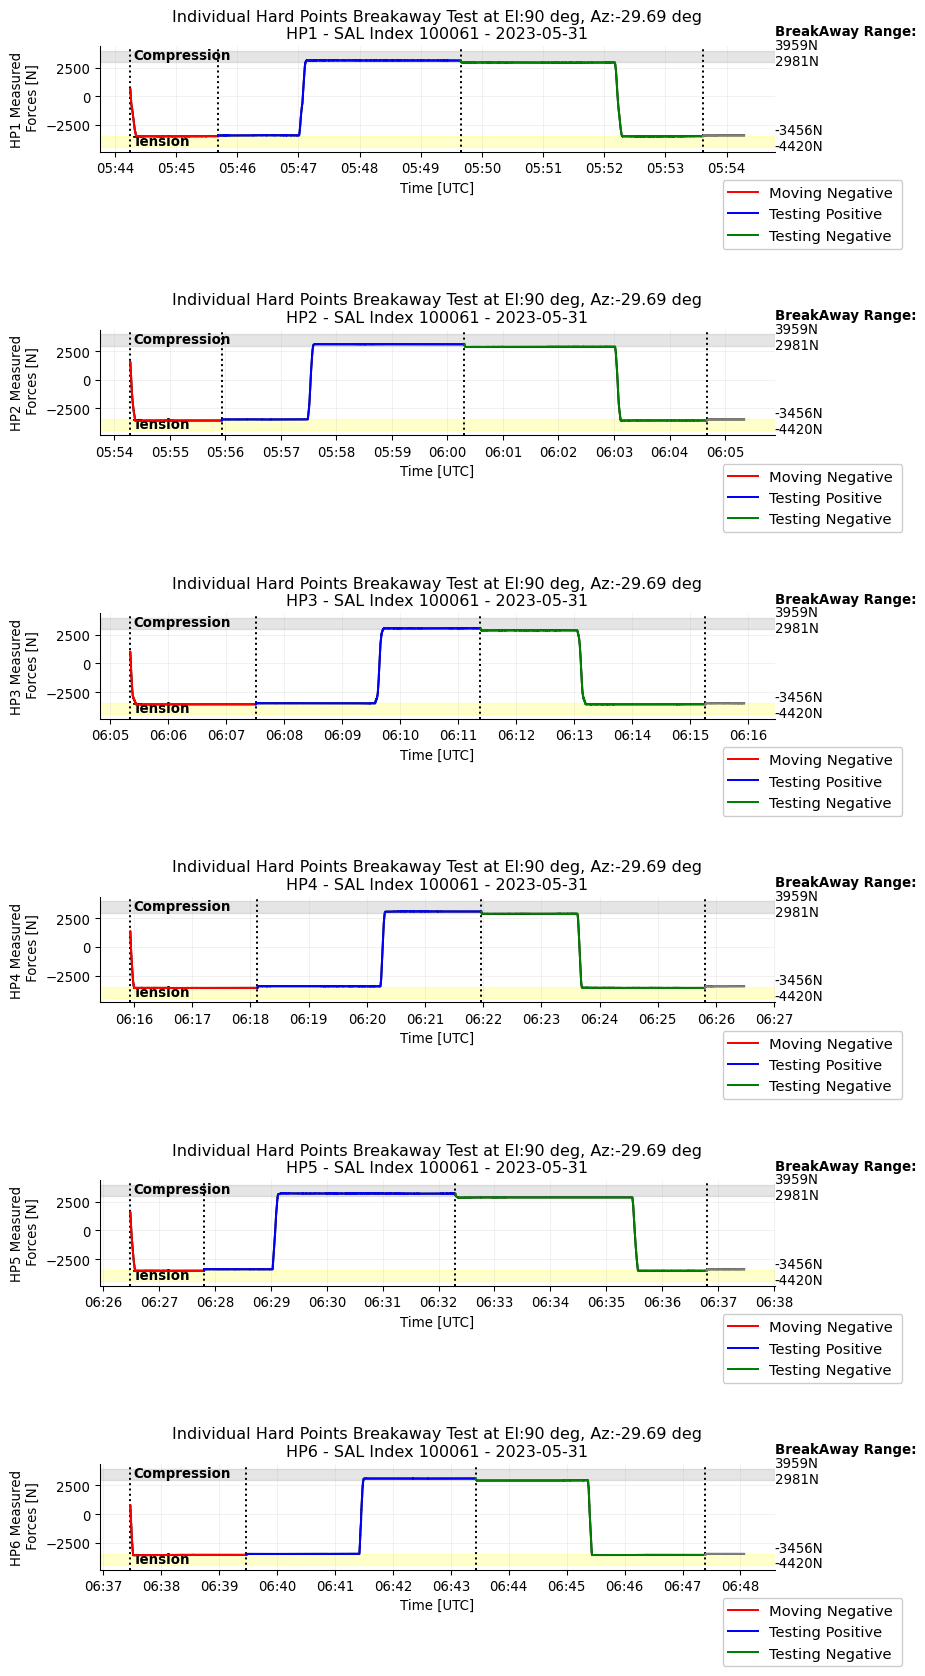

In [36]:
fig, axs = plt.subplots(number_of_hardpoints, 1, figsize=(10, 18), dpi=96)

for hp_index in range(number_of_hardpoints):

    handles=[]
    df_script_sub = df_script[df_script["message"].str.contains(f"Hard point {hp_index + 1} test")]
    df = df_hp.loc[df_script_sub.index[0]:df_script_sub.index[-1]]    
   # hp_test = df_hp[df_hp["hardpointActuator"] == hp_index + 1]


    # Create plot axes
    #fig, axs = plt.subplots(num=f"hp_timeline_{hp_index}", figsize=(10, 3), dpi=96)

    
    # Show the data
    axs[hp_index].plot(df[f"measuredForce{hp_index}"], zorder=5, color='black')
    
    #enumerations for HardpointTest. 
    MovingNegative= df_hp_status[df_hp_status[f"testState{hp_index}"] == 2 ].index.values
    TestingPositive= df_hp_status[df_hp_status[f"testState{hp_index}"] == 3 ].index.values
    TestingNegative=df_hp_status[df_hp_status[f"testState{hp_index}"] == 4 ].index.values
    MovingReference=df_hp_status[df_hp_status[f"testState{hp_index}"] == 5 ].index.values

    
    # Add some props to the plot
    axs[hp_index].grid("-", lw=0.5, alpha=0.25)
    axs[hp_index].set_ylabel(f"HP{hp_index + 1} Measured\n Forces [N]")
    axs[hp_index].set_xlabel("Time [UTC]")
    
    # Format x-axis with time
    axs[hp_index].xaxis.set_major_locator(mdates.MinuteLocator())  
    axs[hp_index].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  
    
    # Clean up the plot
    axs[hp_index].spines['top'].set_visible(False)
    axs[hp_index].spines['right'].set_visible(False)
    comp_min = 2981 ; comp_max=3959
    tens_min = -4420; tens_max=-3456
    
    #Seperate the status of the hard points
    axs[hp_index].axvline(MovingNegative, color='k', linestyle=':')
    axs[hp_index].axvline(TestingPositive, color='k', linestyle=':')
    axs[hp_index].axvline(TestingNegative, color='k', linestyle=':')
    axs[hp_index].axvline(MovingReference, color='k', linestyle=':')

    
    axs[hp_index].axhspan(comp_min, comp_max, color="grey", alpha=0.2)
    axs[hp_index].axhspan(tens_min, tens_max, color="yellow", alpha=0.2)
    
    #Input some texts on the plots

    axs[hp_index].text(0.05, 0.875, 'Compression', transform=axs[hp_index].transAxes, weight="bold")
    axs[hp_index].text(0.05, 0.065, "Tension", transform=axs[hp_index].transAxes, weight="bold")
    axs[hp_index].text(1.00, 1.100, 'BreakAway Range:', transform=axs[hp_index].transAxes, weight="bold")
    axs[hp_index].text(1.00, 0.820, f"{comp_min}" + 'N', transform=axs[hp_index].transAxes)
    axs[hp_index].text(1.00, 0.970, f"{comp_max}" + 'N', transform=axs[hp_index].transAxes)
    axs[hp_index].text(1.00, 0.020, f"{tens_min}" + 'N', transform=axs[hp_index].transAxes)
    axs[hp_index].text(1.00, 0.170, f"{tens_max}" + 'N', transform=axs[hp_index].transAxes)
    
   
    #Define the region of 1) Moving HP in the Negative Force 2) Testing HP on Positive Force 3) Testing HP on Negative Force. 
        
    MovingNegative_HP=df[f"measuredForce{hp_index}"][(df.index.values > MovingNegative[0]) & (df.index.values <  TestingPositive[0])]
    TestingPositive_HP=df[f"measuredForce{hp_index}"][(df.index.values > TestingPositive[0]) & (df.index.values <  TestingNegative[0])]
    TestingNegative_HP=df[f"measuredForce{hp_index}"][(df.index.values > TestingNegative[0]) & (df.index.values <  MovingReference[0])]
    MovingReference_HP=df[f"measuredForce{hp_index}"][(df.index.values >  MovingReference[0])]
    
    MovingNegative_displacement_HP=m_to_um*df[f"displacement{hp_index}"][(df.index.values > MovingNegative[0]) & (df.index.values <  TestingPositive[0])]
    TestingPositive_displacement_HP=m_to_um*df[f"displacement{hp_index}"][(df.index.values > TestingPositive[0]) & (df.index.values <  TestingNegative[0])]
    TestingNegative_displacement_HP=m_to_um*df[f"displacement{hp_index}"][(df.index.values > TestingNegative[0]) & (df.index.values <  MovingReference[0])]
    MovingReference_displacement_HP=m_to_um*df[f"displacement{hp_index}"][(df.index.values >  MovingReference[0])]

    
    axs[hp_index].plot(MovingNegative_HP,color='r',zorder=5)
    axs[hp_index].plot(TestingPositive_HP,color='blue',zorder=5)
    axs[hp_index].plot(TestingNegative_HP,color='g',zorder=5)
    axs[hp_index].plot(MovingReference_HP,color='grey',zorder=5)

    
    line1 = Line2D([0], [0], label='Moving Negative', color='r')
    line2 = Line2D([0], [0], label='Testing Positive',color='b')
    line3 = Line2D([0], [0], label='Testing Negative ',color='g')
    
    handles.extend([line1,line2, line3])
    
    axs[hp_index].legend(handles=handles,fontsize=11,framealpha=1,bbox_to_anchor=(1.2, -0.2))

    
    axs[hp_index].set_title(f"Individual Hard Points Breakaway Test at El:{El} deg, Az:{Az} deg\n"
                 f"HP{hp_index+1} - SAL Index {sal_index} - {df.index[0].strftime('%Y-%m-%d')}")
    #fig.autofmt_xdate()
    fig.show()


os.makedirs("plots", exist_ok=True)
fig.tight_layout(pad=2.0)
fig.savefig(f"plots/m1m3004_hp_timeline_El_{El}.png", dpi=150, bbox_inches="tight")

    


Now plot the hystersis for each hardpoint. <br> 

1. Plot HP measured forces for each moving status with respect to displacement. <br>
2. In order to compare the shape of hystersis, zero point of each phase is shifted to displacement= 0.  <br> 
3. Then, find the fitted hardpoint stiffness - find the linear slopes at F=0. Add the slope for the specification (100N/um) <br>



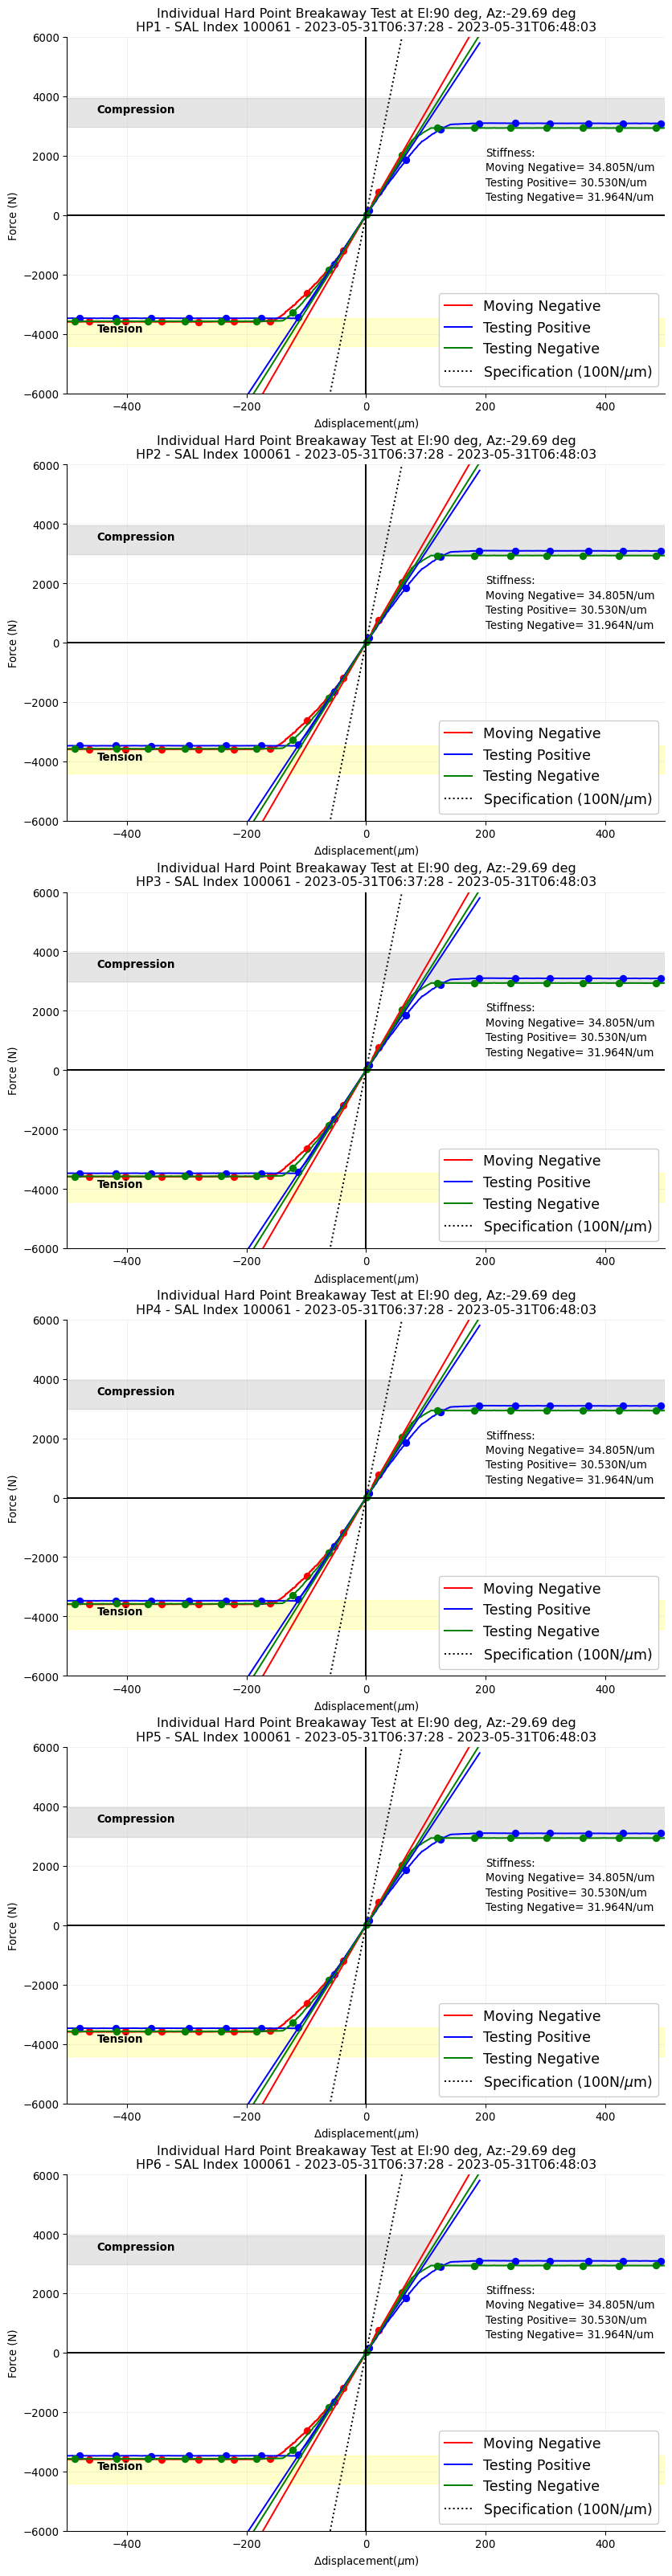

In [37]:
fig, axs = plt.subplots(number_of_hardpoints, 1, figsize=(10, 42), dpi=96)

for hp_index in range(number_of_hardpoints):
    
    handles=[]
    
    MovingNegative_HP=df[f"measuredForce{hp_index}"][(df.index.values > MovingNegative[0]) & (df.index.values <  TestingPositive[0])]
    TestingPositive_HP=df[f"measuredForce{hp_index}"][(df.index.values > TestingPositive[0]) & (df.index.values <  TestingNegative[0])]
    TestingNegative_HP=df[f"measuredForce{hp_index}"][(df.index.values > TestingNegative[0]) & (df.index.values <  MovingReference[0])]
    MovingReference_HP=df[f"measuredForce{hp_index}"][(df.index.values >  MovingReference[0])]
    
    MovingNegative_displacement_HP=m_to_um*df[f"displacement{hp_index}"][(df.index.values > MovingNegative[0]) & (df.index.values <  TestingPositive[0])]
    TestingPositive_displacement_HP=m_to_um*df[f"displacement{hp_index}"][(df.index.values > TestingPositive[0]) & (df.index.values <  TestingNegative[0])]
    TestingNegative_displacement_HP=m_to_um*df[f"displacement{hp_index}"][(df.index.values > TestingNegative[0]) & (df.index.values <  MovingReference[0])]
    MovingReference_displacement_HP=m_to_um**df[f"displacement{hp_index}"][(df.index.values >  MovingReference[0])]
  
    
    zero_force_point_MN = hp_force_MovingNegative.index.get_loc(hp_force_MovingNegative.abs().idxmin())
    zero_force_point_TP = hp_force_TestingPositive.index.get_loc(hp_force_TestingPositive.abs().idxmin())
    zero_force_point_TN = hp_force_TestingNegative.index.get_loc(hp_force_TestingNegative.abs().idxmin())
        
    if (zero_force_point_MN > 0) and (zero_force_point_TP > 0) and (zero_force_point_TN > 0):
        
        min_MN = min (zero_force_point_MN, 10)
        min_TP = min (zero_force_point_TP, 10) 
        min_TN = min (zero_force_point_TN, 10) 
 

        m_MN, b_MN = np.polyfit(hp_displacement_MovingNegative[zero_force_point_MN-min_MN:zero_force_point_MN+min_MN],\
                                hp_force_MovingNegative[zero_force_point_MN-min_MN:zero_force_point_MN+min_MN], 1)
        m_TP, b_TP = np.polyfit(hp_displacement_TestingPositive[zero_force_point_TP-min_TP:zero_force_point_TP+min_TP],\
                                hp_force_TestingPositive[zero_force_point_TP-min_TP:zero_force_point_TP+min_TP], 1)
        m_TN, b_TN = np.polyfit(hp_displacement_TestingNegative[zero_force_point_TN-min_TN:zero_force_point_TN+min_TN],\
                                hp_force_TestingNegative[zero_force_point_TN-min_TN:zero_force_point_TN+min_TN], 1)

        x_zero_MN = -b_MN/m_MN ;  x_zero_TP = -b_TP/m_TP; x_zero_TN = -b_TN/m_TN

        x=(np.arange(40)-20)*10
        axs[hp_index].plot(hp_displacement_MovingNegative-x_zero_MN, hp_force_MovingNegative, color='r')
        axs[hp_index].plot(hp_displacement_MovingNegative-x_zero_MN, hp_force_MovingNegative, color='r', marker='o',markevery=50)
        axs[hp_index].plot(hp_displacement_TestingPositive-x_zero_TP, hp_force_TestingPositive, color='b', marker='o',markevery=50)
        axs[hp_index].plot(hp_displacement_TestingNegative-x_zero_TN, hp_force_TestingNegative, color='g', marker='o',markevery=50)

        axs[hp_index].plot(x, x*m_MN, color='r')
        axs[hp_index].plot(x, x*m_TP, color='b')
        axs[hp_index].plot(x, x*m_TN, color='g')
        axs[hp_index].plot(x, x*100, ':', color='k')


        line1 = Line2D([0], [0], label='Moving Negative', color='r')
        line2 = Line2D([0], [0], label='Testing Positive',color='b')
        line3 = Line2D([0], [0], label='Testing Negative ',color='g')
        line4 = Line2D([0], [0], label='Specification (100N/${\mu}$m)',linestyle=':',color='k')


        axs[hp_index].text(200,2000,"Stiffness:")
        axs[hp_index].text(200,1500,"Moving Negative= " +f"{m_MN:.3f}N/um")
        axs[hp_index].text(200,1000,"Testing Positive= " +f"{m_TP:.3f}N/um")
        axs[hp_index].text(200,500,"Testing Negative= " +f"{m_TN:.3f}N/um")


        handles.extend([line1,line2, line3, line4])

        axs[hp_index].legend(handles=handles,fontsize=13,framealpha=1,loc="lower right")

        # Add axis labels
        axs[hp_index].set_xlabel('${\Delta}$displacement(${\mu}$m)')
        axs[hp_index].set_ylabel('Force (N)')

        # Add grid and legend to plot
        axs[hp_index].grid("-", lw=0.5, alpha=0.25)

        axs[hp_index].spines['top'].set_visible(False)
        axs[hp_index].spines['right'].set_visible(False)
        axs[hp_index].xaxis.set_ticks_position('bottom')
        axs[hp_index].set_xlim(-500,500)
        axs[hp_index].set_ylim(-6000,6000)
        axs[hp_index].axhspan(comp_min, comp_max, color="grey", alpha=0.2)
        axs[hp_index].axhspan(tens_min, tens_max, color="yellow", alpha=0.2)

        axs[hp_index].axhline(y=0, color='k')
        axs[hp_index].axvline(x=0, color='k')

        axs[hp_index].text(-450, np.mean([comp_min,comp_max]), 'Compression',weight="bold")
        axs[hp_index].text(-450, np.mean([tens_min,tens_max]), "Tension",weight="bold")

        # Add title to plot
    title = (f"Individual Hard Point Breakaway Test at El:{El} deg, Az:{Az} deg\n"
             f"HP{hp_index + 1} - SAL Index {sal_index} -"
             f" {df.index[0].isoformat(timespec='seconds')[:-6]} -"
             f" {df.index[-1].isoformat(timespec='seconds')[:-6]}")
    axs[hp_index].set_title(f"{title}")

    # Save plot as png file
os.makedirs("plots", exist_ok=True)
filename = f"Force_displacement_salidx_{sal_index}_El_{El}.png"
fig.savefig(f"plots/{filename}", dpi=150, bbox_inches="tight")
plt.show()